## Creating Functions

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import glob
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import dump, load

def read_all_csvs_to_df(directory_path):
    pattern = f"{directory_path}/*.csv"
    csv_files = glob.glob(pattern)
    data_rows = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        df_complex = df.map(complex)
        df_real = df_complex.map(np.real)
        flattened_data = df_real.values.flatten()
        data_rows.append(flattened_data)
    final_df = pd.DataFrame(data_rows)
    final_df.columns = [f'col_{i}' for i in range(final_df.shape[1])]
    return final_df

def prepare_for_tsfresh(df):
    final_df = df.transpose()
    final_df = final_df.groupby(np.arange(len(final_df))//25).mean()
    final_df = final_df.transpose()
    final_df = final_df.melt(ignore_index=False).reset_index()
    final_df.columns = ['unique_id', 'ds', 'y']
    final_df["ds"] = final_df["ds"].astype(int)
    final_df = final_df.set_index('ds')
    return final_df

def read_live_csvs_to_df(directory_path):
    pattern = f"{directory_path}/*.csv"
    csv_files = glob.glob(pattern)
    exists = False
    for csv_file in csv_files:
        if exists == False:
            final_df = pd.read_csv(csv_file)
            exists = True
        else:
            new_df = pd.read_csv(csv_file)
            final_df = pd.concat([final_df.copy(), new_df], ignore_index=True)
    return final_df

## Importing the Data

In [2]:
current_directory = os.getcwd()
blinks = read_all_csvs_to_df(current_directory + "\\train_data\\blinks")
left = read_all_csvs_to_df(current_directory + "\\train_data\\left")
right = read_all_csvs_to_df(current_directory + "\\train_data\\right")
nonevents = read_all_csvs_to_df(current_directory + "\\train_data\\non_events")

blinks_live = read_live_csvs_to_df(current_directory + "\\train_data\\blinks_live")
left_live = read_live_csvs_to_df(current_directory + "\\train_data\\left_live")
right_live = read_live_csvs_to_df(current_directory + "\\train_data\\right_live")

In [3]:
blinks = pd.concat([blinks.copy(), blinks_live.copy()], ignore_index=True)
left = pd.concat([left.copy(), left_live.copy()], ignore_index=True)
right = pd.concat([right.copy(), right_live.copy()], ignore_index=True)

In [4]:
blinks['label'] = 0
left['label'] = 1
right['label'] = 2
nonevents['label'] = 4

combined = pd.concat([blinks, left, right, nonevents], axis = 0)

## Creating Train and Test Sets

In [7]:
# Normal Code
X = combined.drop('label', axis=1)
y = combined['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Creating Model with Default Parameters

In [8]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

## Testing Model

Accuracy: 0.9349593495934959


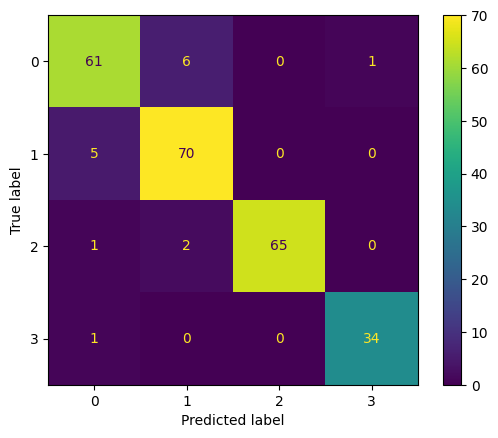

In [9]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Grid Search

In [10]:
grid_space={'max_depth':[5,10,None],
              'n_estimators':[50,100,200],
              'max_features':['sqrt',5,7],
              'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10]
           }

rf = RandomForestClassifier()

grid = GridSearchCV(rf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score is: 0.9461382113821138


## Creating Model with Optimised Parameters and Testing on Test Set

Accuracy: 0.9512195121951219


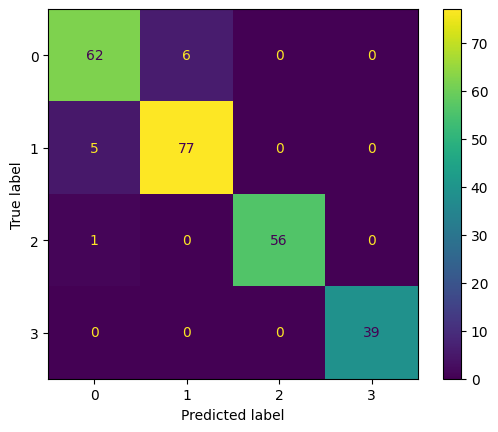

In [11]:
rf = RandomForestClassifier(max_depth = 10, max_features = 5, min_samples_leaf = 1, min_samples_split = 2 , n_estimators = 100)
rf.fit(X_train, y_train)

dump(rf, 'live_rf_b_l_r_ne_combined.joblib') 

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()